<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Introduction to Linear Regression

_Author:_ Tim Book

### Learning Objectives 
- Describe modeling.
- Calculate mean squared error.
- State the assumptions of a linear regression model.
- Be able to interpret the coefficients of a linear regression model.
- Identify the difference between simple and multiple linear regression.
- Fit, generate predictions from, and evaluate a linear regression model in `sklearn`, and maybe in `statsmodels`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## The Data
Data source: [here](https://www.rdocumentation.org/packages/fpp2/versions/2.3/topics/elecdemand)

The data consist of electricity demand for Victoria, Australia every half-hour in 2014. We have three columns:

* Total electricity demand (in gigawatts)
* Whether or not it is a workday (0/1)
* Temperature (Celcius)

In [2]:
elec = pd.read_csv("../data/elecdemand.csv")

# We'll limit our focus to only days in which it was
# at least 15 degrees Celcius (59 F)
elec = elec[elec["temp"] > 15]

print(elec.shape)
elec.head()

(9807, 3)


,demand,workday,temp
0,3.914647,0,18.2
1,3.672550,0,17.9
2,3.497539,0,17.6
3,3.339145,0,16.8
4,3.204313,0,16.3


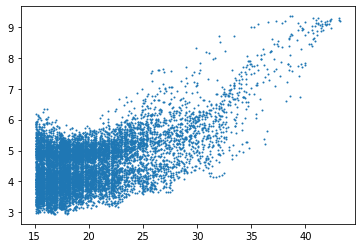

In [3]:
# Plot temperature vs. demand
plt.scatter(elec["temp"], elec["demand"], s=1);

In [4]:
# Step 1: Assemble our X and y variables

# We need an X matrix that is n-by-p (in this case, p = 1)
X = elec[["temp"]]

# We need a y vector that is length n
y = elec["demand"]

In [5]:
# Step 2: Import our model class
from sklearn.linear_model import LinearRegression

In [6]:
# Step 3: Instantiate the model
lr = LinearRegression()

In [7]:
# Step 4: Fit the model
lr.fit(X, y)

LinearRegression()

In [8]:
# Take a peek at the model coefficient and intercept
print(lr.intercept_)
print(lr.coef_)

2.318762978267356
[0.11415682]


## Results
We now have the following model of reality:

$$\hat{d} = 2.32 + 0.11t$$

#### Interpretation of our slope.
For every 1 degree increase in temperature, we would expect 0.11 more gigawatts of electricty to be demanded. 

#### Interpretation of our y-intercept. Does it make sense?

When it is zero degrees Celcius, we expect 2.32 gigawatts of electricity to be demanded. Ordinarily, this _would_ make sense, however, we have no data near this value and would want to avoid **extrapolation**.

In [9]:
# Make predictions
y_pred = lr.predict(X)

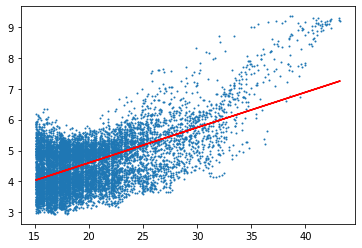

In [10]:
# We can plot them, too!
plt.scatter(elec["temp"], elec["demand"], s=1)
plt.plot(elec["temp"], y_pred, color='red');

## Evaluation

$$ MSE = \frac{1}{n} \sum (y_i - \hat{y}_i)^2 = \frac{1}{n} \sum e_i^2 $$

In [11]:
# Creat residuals
resids = y - y_pred

In [12]:
# (THREAD) Compute the MSE
mse = np.mean(resids**2)
mse

0.5050316037069883

**(THREAD)** Suppose we had no _x_-variable at all. What would be our best guess for each $\hat{y}_i$?

In [13]:
# Create the predictions for the "null model"
y_bar = np.mean(y)

In [14]:
# The null MSE
null_mse = np.mean((y - y_bar)**2)
null_mse

0.7796885466312027

Another popular regression metric is the $R^2$, which is defined as:

$$R^2 = 1 - \frac{\text{MSE}}{\text{Null MSE}} = 1 - \frac{\sum (y_i - \hat{y}_i)}{\sum (y_i - \bar{y})}$$

The $R^2$, or **coefficient of determination**, is the proportion of variability in $y$ we can explain with $x$.

In [15]:
# The R2
1 - mse / null_mse

0.35226494490771165

#### Interpret R2

35.2% of the variability in electricity demand can be explained by temperature.

In [16]:
from sklearn import metrics

In [17]:
# Can compute it from metrics...
metrics.r2_score(y, y_pred)

0.3522649449077143

In [18]:
# ... or directly from the model...
lr.score(X, y)

0.3522649449077143

## NOW YOU

Fit the model of demand versus temperature _and_ workday, and compute the $R^2$. For an added bonus challenge, try to fit the model of demand versus temperature, temperature **squared**, and workday, and again compute the $R^2$.

In [19]:
X = elec[["temp", "workday"]]
X["temp2"] = elec["temp"]**2

In [20]:
lr2 = LinearRegression()
lr2.fit(X, y)

LinearRegression()

In [21]:
lr2.score(X, y)

0.5822444810367917

## LINE Assumptions
Let's check em!

In [22]:
# L - see above plot(s)

In [23]:
# I - Yes, by assumption?

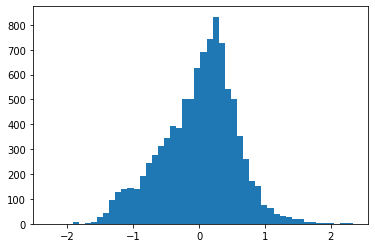

In [24]:
# N - Normality of errors
resids = y - lr2.predict(X)
plt.hist(resids, bins=50);

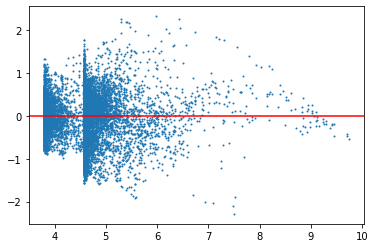

In [25]:
# E - Equal variance of errors
plt.scatter(lr2.predict(X), resids, s=1)
plt.axhline(0, color="red");

# Part II: Multiple Linear Regression (MLR) and Categorical Features

## Bikeshare Data
Data adapted from source: [here](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset)

In [26]:
bike = pd.read_csv("../data/bikeshare.csv")
print(bike.shape)
bike.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [27]:
# Some preprocessing:
# 1 - Rename "count" to "riders"
# 2 - Drop "casual" and "registered"
# 3 - Cast "datetime" to actually be a datetime
# 4 - Drop only row where weather == 4
bike.rename(columns={"count": "riders"}, inplace=True)
bike.drop(columns=["casual", "registered"], inplace=True)
bike = bike[bike["weather"] != 4]
bike["datetime"] = pd.to_datetime(bike["datetime"])

In [28]:
bike.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,riders
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1


In [29]:
# Season vs Month
pd.crosstab(bike["season"], bike["datetime"].dt.month)

datetime,1,2,3,4,5,6,7,8,9,10,11,12
season,,,,,,,,,,,,
1,883,901,901,0,0,0,0,0,0,0,0,0
2,0,0,0,909,912,912,0,0,0,0,0,0
3,0,0,0,0,0,0,912,912,909,0,0,0
4,0,0,0,0,0,0,0,0,0,911,911,912


### Ridership model
Let's try to predict the number of riders based on temperature and what season it is. We'll have to **dummify** the season column!

In [30]:
# Dummify "season"
X = bike[["season", "temp"]]
X = pd.get_dummies(columns=["season"], drop_first=True, data=X)

y = bike["riders"]

In [31]:
X.head()

,temp,season_2,season_3,season_4
0,9.84,0,0,0
1,9.02,0,0,0
2,9.02,0,0,0
3,9.84,0,0,0
4,9.84,0,0,0


In [32]:
# Fit model
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [33]:
# Coefficients
model.coef_

array([  13.74269709,  -42.50544518, -105.32350516,   26.08224525])

### Interpretation of coefficients
Now that we have multiple variables, our interpretation are **holding all other variables constant**. Furthermore, each interpretation of a dummy variable is **in relation to the baseline** (in this case, Winter).

**Interpretation of $\hat{\beta}_3$:**
Holding the temperature constant, the effect of it being Summer contributs to 105 fewer riders per hour relative to Winter.

## NOW YOU
Now your turn: Fit a model that uses _all_ x-variables (excluding `atemp`) as well as the **the hour of day**. Dummify columns accordingly.

In [34]:
bike.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,riders
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1


In [35]:
bike["hour"] = bike["datetime"].dt.hour

xvars = [
    "season", "holiday", "workingday",
    "weather", "temp", "humidity",
    "windspeed", "hour"
]

X = bike[xvars]
X = pd.get_dummies(columns=["season", "weather", "hour"], data=X, drop_first=True)

In [36]:
X.head()

,holiday,workingday,temp,humidity,windspeed,season_2,season_3,season_4,weather_2,weather_3,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,0,0,9.84,81,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,9.02,80,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,9.02,80,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,9.84,75,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,9.84,75,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
model_big = LinearRegression()
model_big.fit(X, y)

LinearRegression()

In [38]:
model_big.score(X, y)

0.6321452699700186

# Additional, not-really-BONUS topics

## ANRBT #1: Multicollinearity
Multicollinearity occurs when you have two or more $x$-variables that are correlated with eachother. This phenomenon doesn't affect the quality of the model fit, but it completely destroys model inference (ie, confidence intervals and hypothesis tests, more on this next week). In addition, it can also contribution to a **rank-deficient matrix**, meaning the model can't be fit at all!

In [39]:
np.corrcoef(bike.temp, bike.atemp)

array([[1.        , 0.98494541],
       [0.98494541, 1.        ]])

## ANRBT #2: The Curse of Dimensionality
It turns out that the more variables we add to our model, the better it is. Actually, it doesn't even matter what this variable was, that will always be true. Even if it's completely irrelevant. That is, if we added the following variables to our model:

* Is there a sunspot on this day?
* The closing stock price of Apple that day.
* Whether or not Guy Fieri had pancakes for breakfast that day.
* A column of completely random standard normal variables

Our model is **guaranteed** to get better. But it isn't _really_ a better model, right? It turns out, we're modeling **noise**, not **signal**. We'll talk more about this phenomenon later.

## ANRBT #3: Matrix Notation and Solution
Recall our matrix notations:

$$
\mathbf{y} = \begin{bmatrix} y_1 & y_2 & \cdots & y_n \end{bmatrix}^T
$$

$$
\beta = \begin{bmatrix} \beta_0 & \beta_1 & \cdots & \beta_p \end{bmatrix}^T
$$

$$
\mathbf{X} = \begin{bmatrix}
1 & x_{11} & x_{12} & \cdots & x_{1p} \\
1 & x_{21} & x_{22} & \cdots & x_{2p} \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
1 & x_{n1} & x_{n2} & \cdots & x_{np} \\ 
\end{bmatrix}
$$

It then works out we can write our model as:

$$\mathbf{y} = \mathbf{X}\beta + \varepsilon$$

Which makes our solution:

$$\mathbf{\hat{y}} = \mathbf{X}\hat{\beta}$$

where

$$\hat{\beta} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}$$

Look confusing? It is! It haunts the dreams of second-year grad students. But it's not _too_ mysterious. If you'd like to understand it better, check out the **numpy ladder challenge**. Really, the take away here is singular:

### **The solution to our problem exists in closed form and can be computed by simple matrix multiplication.**

## ANRBT #4: The `statsmodels` Library
Scikit-Learn does not hold the monopoly in doing linear regression in Python. In fact, you may even like this better!

In [40]:
import statsmodels.api as sm

X = elec[["temp", "workday"]]
X = sm.add_constant(X)
y = elec["demand"]
ols = sm.OLS(y, X).fit()

In [41]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 demand   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     5311.
Date:                Fri, 02 Sep 2022   Prob (F-statistic):               0.00
Time:                        20:01:51   Log-Likelihood:                -9095.8
No. Observations:                9807   AIC:                         1.820e+04
Df Residuals:                    9804   BIC:                         1.822e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7821      0.029     60.732      0.000       1.725       1.840
temp           0.1145      0.001     85.071      0.000       0.112       0.117
workday        0.7768      0.013     58.541      0.000       0.751       0.803
==============================================================================
Omnibus:                       59.454   Durbin-Watson:                   0.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               83.490
Skew:                           0.060   Prob(JB):                     7.42e-19
Kurtosis:                       3.436   Cond. No.                         99.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Conclusions and Takeaways:
* Machine learning, aka statistical modeling, is an important and vast topic we'll spend much of our course exploring. It comes in many varieties for different situations.
* Linear regression is a **supervised "white-box" regression model**.
* As far as machine learning goes, OLS is very simple, yet still powerful.
* One of its more enticing feature is that its **coefficients are interpretable!**
* In the midst of all this, we learned how to handle dummy variables, something important for all of the models we'll learn about.